# 스마트시티 화재 피해량 예측

# 프로젝트 준비
## 라이브러리 임포트

In [151]:
import os
import numpy as np
import pandas as pd
import requests
import json
import pprint
import time
import lightgbm as lgb
import xgboost as xgb
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from geopy.geocoders import Nominatim
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from math import sqrt


from sklearn.model_selection import cross_val_score

from  sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
import joblib

In [99]:
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Nanum Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

## 데이터 불러오기

In [100]:
df = pd.read_csv("화재출동 현황 2023.csv")
df.columns = df.columns.str.lower() #---대문자를 소문자로
df.head(2)

,wrinvstg_no,fire_type_nm,buld_srtfrm,buld_strctr,buld_srtrf,buld_strct_dong_cnt,ground_nof,bstory_cnt,totar,bottom_area,buld_sttus_nm,dth_cnt,injpsn_cnt,dth_hnl_dmge_cnt,prprty_dmge_amt,fire_ocrn_yr,season_se_nm,qtr_se,fire_ocrn_ymd,fire_ocrn_tm,fire_ocrn_mnth,fire_ocrn_day,fire_ocrn_hour,fire_ocrn_min,daywk,frstt_nm,ward_nm,lfdau_nm,dsp_reqre_time,fire_supesn_time,sido_nm,sigungu_nm,emd_nm,cty_frmvl_se_nm,emd_se_nm,gis_x_axis,gis_y_axis,longitude,la,spt_frstt_dist,spt_safe_cnter_dist,spt_lfdau_dist,ign_htsrc_nm,ign_htsrc_sclas_nm,ign_fctr_lclas_nm,ign_fctr_sclas_nm,frst_igobj_lclas_nm,frst_igobj_sclas_nm,ign_mhrls_lclas_nm,ign_mhrls_sclas_nm,cmbs_expobj_lclas_nm,cmbs_expobj_sclas_nm,fclty_place_lclas_nm,fclty_place_mclas_nm,fclty_place_sclas_nm,ign_floor_nm,soot_area,fio_join_trgt_yn,frmng_trgt_yn,mub_yn,emrg_crg_oper_yn,vhcle_place,vhcle_ign_bhf,fld_fire_se,fld_fire_ign_bhf,time_unit_tmprt,time_unit_rainqty,time_unit_ws,time_unit_wd,time_unit_humidity,time_unit_msnf,time_unit
0,230101054207011,건축/구조물,양식(옥),철근콘크리트조,슬라브가,1.0,8.0,0.0,989.3,146.69,사용중,0,0,0,5,2023,겨울,1,20230101,43600,1,1,4,36,일요일,금천소방서,금천119안전센터,NaN,300,600,서울특별시,금천구,독산동,도시,동,190482.03,540951.32,NaN,NaN,0.8,0.8,0.0,담뱃불/ 라이터불,담뱃불,부주의,담배꽁초,쓰레기류,쓰레기,NaN,NaN,NaN,NaN,판매/업무시설,숙박시설,기타 숙박시설,1.0,0.0,N,Y,N,N,NaN,NaN,NaN,NaN,1.5,NaN,1.0,290.0,74,NaN,709
1,230101130808916,건축/구조물,양식(옥),철근콘크리트조,슬라브가,1.0,3.0,1.0,1146.0,263.00,사용중,0,0,0,11,2023,겨울,1,20230101,92100,1,1,9,21,일요일,송파소방서,종합운동장119안전센터,NaN,256,812,서울특별시,송파구,잠실동,도시,동,206874.44,544971.00,NaN,NaN,4.5,2.0,0.0,작동기기,전기적 아크(단락),전기적 요인,접촉불량에 의한 단락,전기/전자,콘센트/ 스위치류,배선/배선기구,스위치 멀티탭,NaN,NaN,집합시설,종교시설,교회,-1.0,0.0,N,Y,N,N,NaN,NaN,NaN,NaN,-1.7,NaN,2.0,290.0,75,NaN,763


In [101]:
# 필요한 컬럼만 추출
keep_columns = [
      # 🔹 화재 정보 및 건물 구조
    "buld_strctr", 
    "ground_nof", "bstory_cnt", 'totar', 'bottom_area', 

    # 🔹 피해 정보
    "prprty_dmge_amt", "dth_cnt", "injpsn_cnt",

    # 🔹 계절/요일/기상
    "time_unit_tmprt","time_unit_ws","time_unit_wd","time_unit_humidity",

    # 🔹 지리 및 위치 정보
    'spt_frstt_dist'
]
df = df[keep_columns]
df.columns

Index(['buld_strctr', 'ground_nof', 'bstory_cnt', 'totar', 'bottom_area',
       'prprty_dmge_amt', 'dth_cnt', 'injpsn_cnt', 'time_unit_tmprt',
       'time_unit_ws', 'time_unit_wd', 'time_unit_humidity', 'spt_frstt_dist'],
      dtype='object')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5671 entries, 0 to 5670
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   buld_strctr         4337 non-null   object 
 1   ground_nof          4337 non-null   float64
 2   bstory_cnt          4209 non-null   float64
 3   totar               4337 non-null   float64
 4   bottom_area         4337 non-null   float64
 5   prprty_dmge_amt     5671 non-null   int64  
 6   dth_cnt             5671 non-null   int64  
 7   injpsn_cnt          5671 non-null   int64  
 8   time_unit_tmprt     5671 non-null   float64
 9   time_unit_ws        5650 non-null   float64
 10  time_unit_wd        5650 non-null   float64
 11  time_unit_humidity  5671 non-null   int64  
 12  spt_frstt_dist      5671 non-null   float64
dtypes: float64(8), int64(4), object(1)
memory usage: 576.1+ KB


# EDA, 전처리/가공

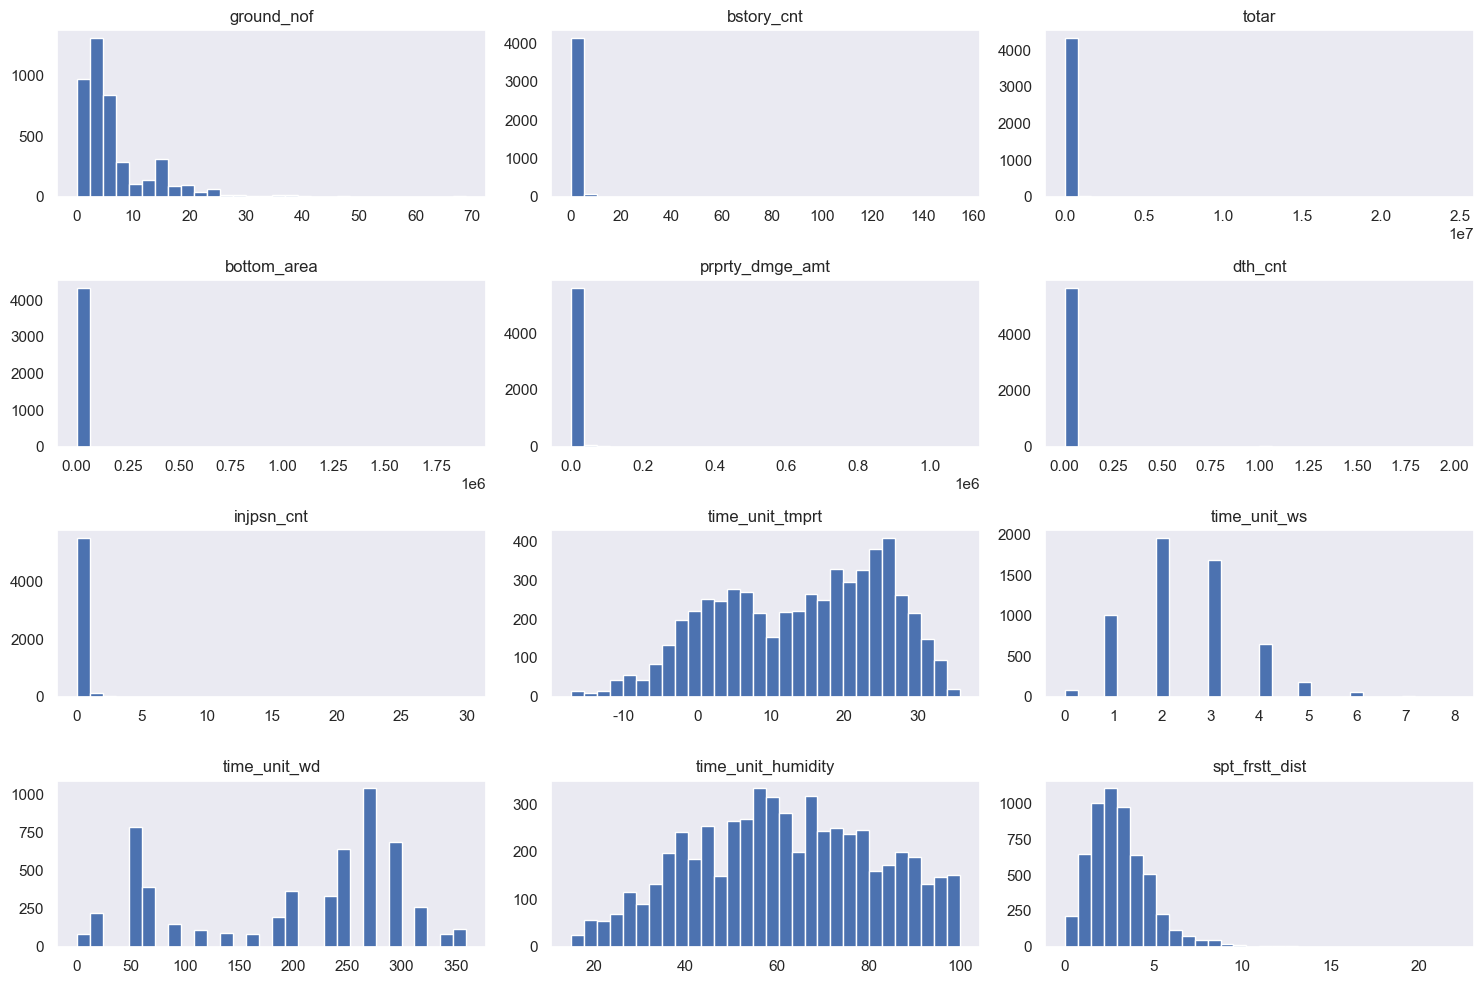

In [103]:
df.hist(figsize=(15, 10), bins=30,  grid=False)
plt.tight_layout() 
plt.show()

## 건물구조 One-Hot Encoding

In [104]:
structure_name_map = {
    "철근콘크리트조": "철근콘크리트구조",
    "벽돌조": "벽돌구조",
    "목조": "일반목구조",
    "블록조": "블록구조",
    "철골조": "일반철골구조",
    "철골철근콘크리트조": "철골철근콘크리트구조",
    "기타 조": "기타",
    "샌드위치패널조": "기타",
    "컨테이너조": "기타",
    "비닐하우스 파이프조": "기타",
    "철조": "기타",
    "치장벽돌조": "벽돌구조"
}
df["buld_strctr"] = df["buld_strctr"].replace(structure_name_map)

structure_manual_map = {
    '기타': 1,
    '벽돌구조': 2,
    '블록구조': 3,
    '일반목구조': 4,
    '일반철골구조': 5,
    '철골철근콘크리트구조': 6,
    '철근콘크리트구조': 7
}

df["buld_strctr_encoded"] = df["buld_strctr"].map(structure_manual_map)

df["buld_strctr_encoded"].value_counts()

buld_strctr_encoded
7.0    3622
2.0     469
1.0      78
4.0      57
3.0      46
5.0      36
6.0      29
Name: count, dtype: int64

In [105]:
encoding_check = dict(
    df[["buld_strctr", "buld_strctr_encoded"]]
    .drop_duplicates()
    .values
)
print(encoding_check)

{'철근콘크리트구조': 7.0, nan: nan, '벽돌구조': 2.0, '일반목구조': 4.0, '일반철골구조': 5.0, '기타': 1.0, '블록구조': 3.0, '철골철근콘크리트구조': 6.0}


In [106]:
df.drop(columns=["buld_strctr"], inplace=True)
df.rename(columns={"buld_strctr_encoded": "buld_strctr"}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5671 entries, 0 to 5670
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ground_nof          4337 non-null   float64
 1   bstory_cnt          4209 non-null   float64
 2   totar               4337 non-null   float64
 3   bottom_area         4337 non-null   float64
 4   prprty_dmge_amt     5671 non-null   int64  
 5   dth_cnt             5671 non-null   int64  
 6   injpsn_cnt          5671 non-null   int64  
 7   time_unit_tmprt     5671 non-null   float64
 8   time_unit_ws        5650 non-null   float64
 9   time_unit_wd        5650 non-null   float64
 10  time_unit_humidity  5671 non-null   int64  
 11  spt_frstt_dist      5671 non-null   float64
 12  buld_strctr         4337 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 576.1 KB


In [107]:
mapping_dict = {
    '철근콘크리트구조': 7, '벽돌구조': 2, '일반목구조': 4,
    '일반철골구조': 5, '기타': 1, '블록구조': 3,
    '철골철근콘크리트구조': 6
}
reverse_mapping_dict = {v: k for k, v in mapping_dict.items()}
df['구조명'] = df['buld_strctr'].map(reverse_mapping_dict)

print("\n===== 1단계: 숫자 코드를 텍스트 라벨로 변환 후 =====")
print(df)

# --- 2단계: 텍스트 라벨 컬럼을 원-핫 인코딩 ---

# pd.get_dummies()를 사용하여 '구조명' 컬럼을 원-핫 인코딩합니다.
# 이 과정에서 기존의 '구조명' 컬럼은 자동으로 삭제됩니다.
df = pd.get_dummies(df, columns=['구조명'], prefix='구조')


===== 1단계: 숫자 코드를 텍스트 라벨로 변환 후 =====
      ground_nof  bstory_cnt      totar  bottom_area  prprty_dmge_amt  \
0            8.0         0.0     989.30       146.69                5   
1            3.0         1.0    1146.00       263.00               11   
2            5.0         1.0    2881.19      1088.16             9454   
3           36.0         7.0  239252.00      2314.70             2719   
4            NaN         NaN        NaN          NaN                5   
...          ...         ...        ...          ...              ...   
5666         6.0         2.0    1896.33       214.23              393   
5667        18.0         0.0    7950.78        84.21              107   
5668         4.0         1.0    1122.00       274.95               25   
5669        28.0         1.0   11447.42       100.11               42   
5670         4.0         1.0    1087.85       275.44               12   

      dth_cnt  injpsn_cnt  time_unit_tmprt  time_unit_ws  time_unit_wd  \
0          

In [108]:
df.drop(columns=['buld_strctr'], inplace=True)
df.rename(columns={'구조_기타': 'strc_etc',
                     '구조_벽돌구조': 'strc_brick',
                     '구조_블록구조': 'strc_block',
                     '구조_일반목구조': 'strc_wood',
                     '구조_일반철골구조': 'strc_steel',
                     '구조_철골철근콘크리트구조': 'strc_src',
                     '구조_철근콘크리트구조': 'strc_rc'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5671 entries, 0 to 5670
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ground_nof          4337 non-null   float64
 1   bstory_cnt          4209 non-null   float64
 2   totar               4337 non-null   float64
 3   bottom_area         4337 non-null   float64
 4   prprty_dmge_amt     5671 non-null   int64  
 5   dth_cnt             5671 non-null   int64  
 6   injpsn_cnt          5671 non-null   int64  
 7   time_unit_tmprt     5671 non-null   float64
 8   time_unit_ws        5650 non-null   float64
 9   time_unit_wd        5650 non-null   float64
 10  time_unit_humidity  5671 non-null   int64  
 11  spt_frstt_dist      5671 non-null   float64
 12  strc_etc            5671 non-null   bool   
 13  strc_brick          5671 non-null   bool   
 14  strc_block          5671 non-null   bool   
 15  strc_wood           5671 non-null   bool   
 16  strc_s

## 아웃라이어 제거 ( 너무 큰값만 제거 )

In [109]:
df['totar'].describe()

count    4.337000e+03
mean     2.208665e+04
std      4.623156e+05
min      0.000000e+00
25%      3.082700e+02
50%      6.798900e+02
75%      3.731240e+03
max      2.464277e+07
Name: totar, dtype: float64

In [110]:
q98 = df['totar'].quantile(0.98)
df = df[df['totar'] <= q98]

<Axes: >

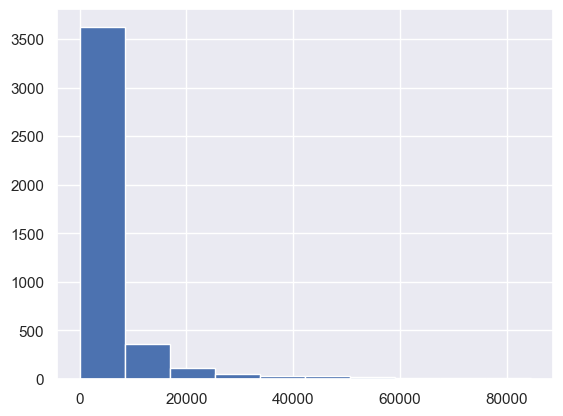

In [111]:
df['totar'].hist()

In [112]:
df['totar'].describe()

count     4250.000000
mean      4274.279831
std       9600.719614
min          0.000000
25%        304.022500
50%        659.805000
75%       3119.870000
max      84502.200000
Name: totar, dtype: float64

In [113]:
df['bottom_area'].describe()

count    4.250000e+03
mean     1.168669e+03
std      3.049526e+04
min      0.000000e+00
25%      8.000000e+01
50%      1.452300e+02
75%      3.531050e+02
max      1.898776e+06
Name: bottom_area, dtype: float64

In [114]:
q99 = df['bottom_area'].quantile(0.99)
df = df[df['bottom_area'] <= q99]

<Axes: >

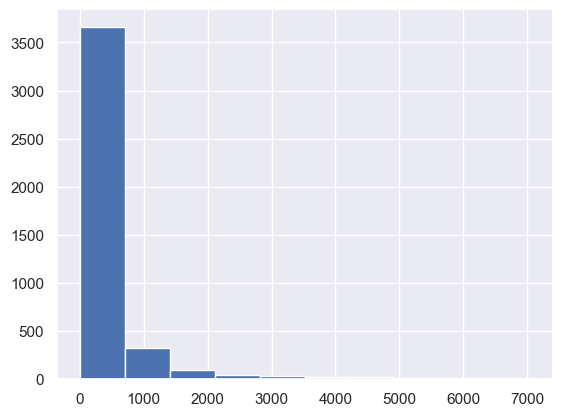

In [115]:
df['bottom_area'].hist()

In [116]:
df['bottom_area'].describe()

count    4207.000000
mean      377.549734
std       715.312535
min         0.000000
25%        79.660000
50%       143.270000
75%       337.620000
max      7053.000000
Name: bottom_area, dtype: float64

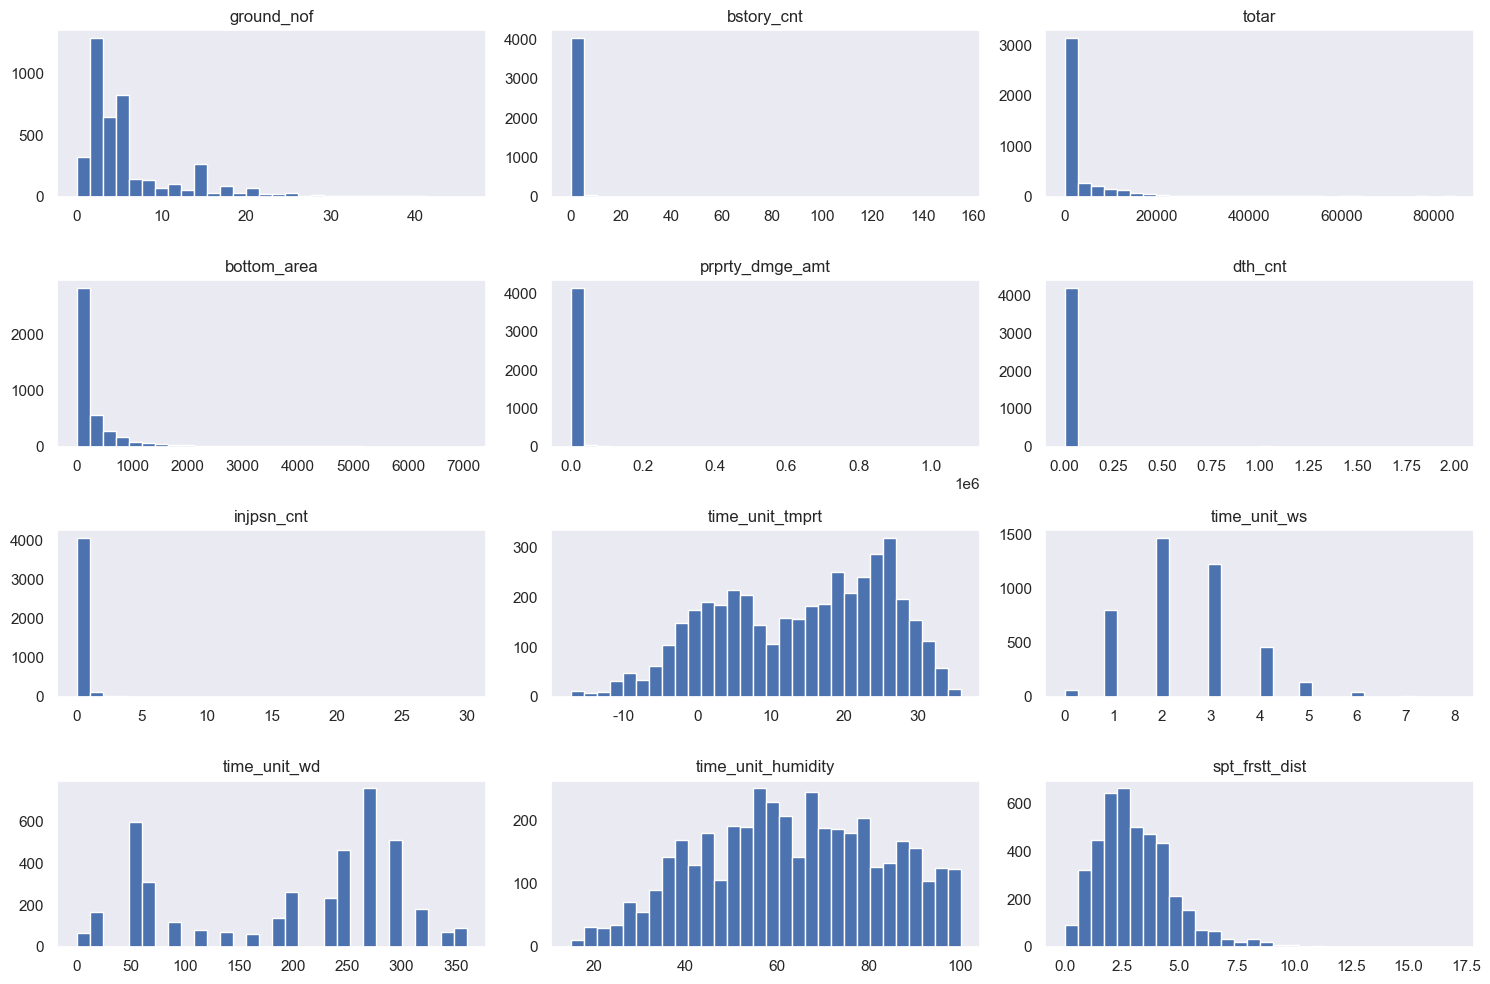

In [117]:
df.hist(figsize=(15, 10), bins=30,  grid=False)
plt.tight_layout() 
plt.show()

In [118]:
df['bstory_cnt'].describe()

count    4081.000000
mean        1.140162
std         2.647503
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       155.000000
Name: bstory_cnt, dtype: float64

In [119]:
df = df.drop(df['bstory_cnt'].idxmax())

In [120]:
df['bstory_cnt'].describe()

count    4080.000000
mean        1.102451
std         1.098169
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: bstory_cnt, dtype: float64

In [121]:
df['ground_nof'].describe()

count    4206.000000
mean        6.365906
std         6.033278
min         0.000000
25%         3.000000
50%         4.000000
75%         7.000000
max        46.000000
Name: ground_nof, dtype: float64

In [122]:
df['prprty_dmge_amt'].describe()

count    4.206000e+03
mean     3.280381e+03
std      2.364836e+04
min      0.000000e+00
25%      2.825000e+01
50%      1.400000e+02
75%      4.960000e+02
max      1.083514e+06
Name: prprty_dmge_amt, dtype: float64

In [123]:
q99 = df['prprty_dmge_amt'].quantile(0.99)
df = df[df['prprty_dmge_amt'] <= q99]

In [124]:
df['prprty_dmge_amt'].describe()

count     4163.000000
mean      1762.132116
std       5657.425510
min          0.000000
25%         28.000000
50%        137.000000
75%        489.500000
max      53004.000000
Name: prprty_dmge_amt, dtype: float64

<Axes: >

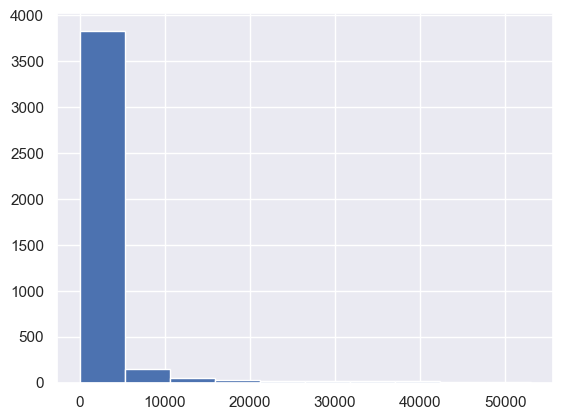

In [125]:
df['prprty_dmge_amt'].hist()

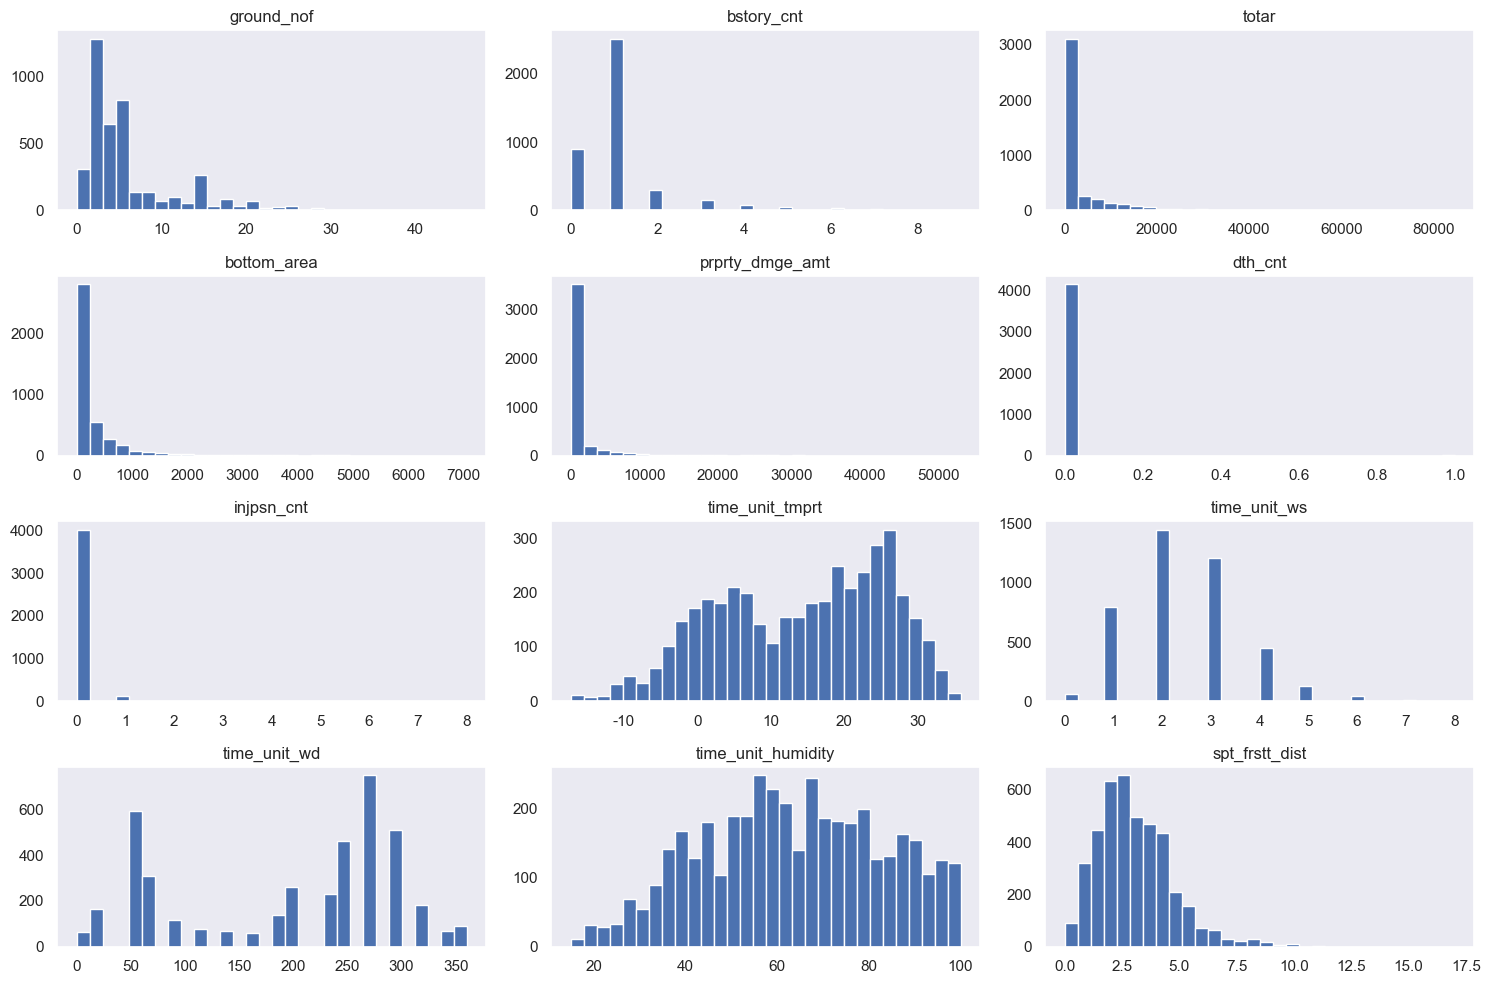

In [126]:
df.hist(figsize=(15, 10), bins=30,  grid=False)
plt.tight_layout() 
plt.show()

In [127]:
df.skew()

ground_nof             2.112339
bstory_cnt             2.583004
totar                  4.383160
bottom_area            4.678028
prprty_dmge_amt        5.402071
dth_cnt               14.705974
injpsn_cnt            10.765105
time_unit_tmprt       -0.300466
time_unit_ws           0.601771
time_unit_wd          -0.432127
time_unit_humidity    -0.074223
spt_frstt_dist         1.230926
strc_etc               7.250027
strc_brick             2.470186
strc_block             9.358113
strc_wood              8.611572
strc_steel            10.617384
strc_src              12.792340
strc_rc               -1.775261
dtype: float64

## 사망자수, 부상자수 이진분류

In [129]:
df['dth_cnt'] = (df['dth_cnt'] > 0).astype(int)
df['dth_cnt'] = (df['injpsn_cnt'] > 0).astype(int)

## 왜도가 1 이상인 컬럼들 log1p

In [130]:
# 왜도가 1 이상인 컬럼 리스트
log_cols = [
    'ground_nof', 'bstory_cnt', 'totar', 'bottom_area',
    'prprty_dmge_amt', 'spt_frstt_dist'
]

# log1p 적용 (음수 방지 위해 clip)
for col in log_cols:
    df[col] = np.log1p(df[col].clip(lower=0))

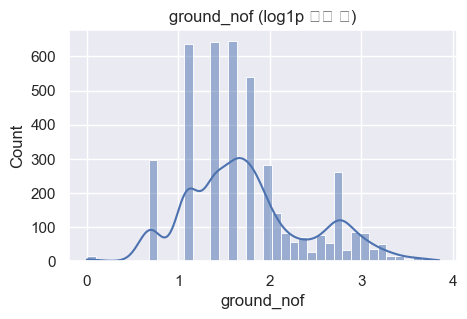

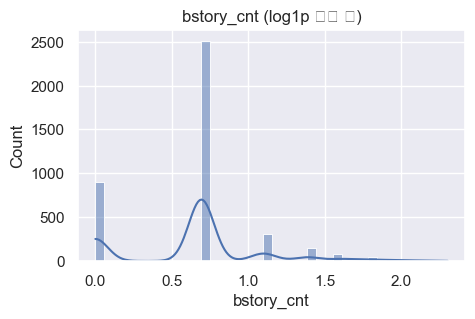

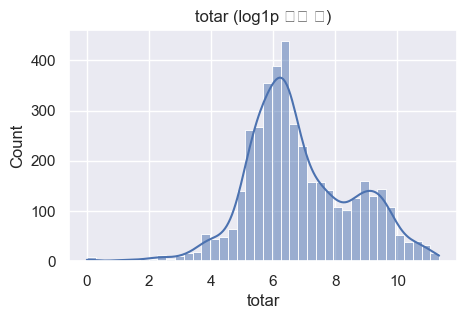

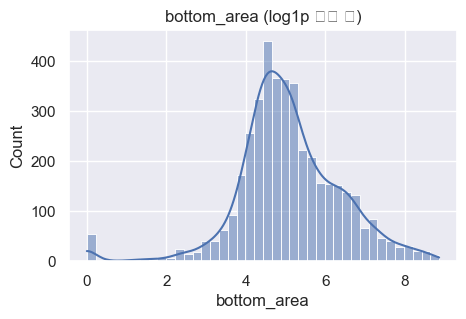

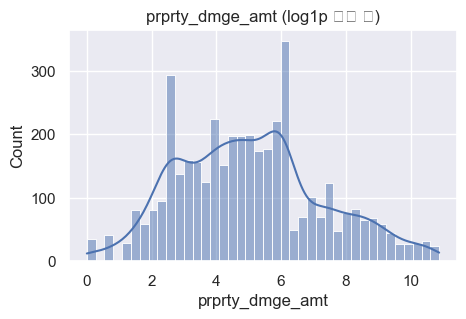

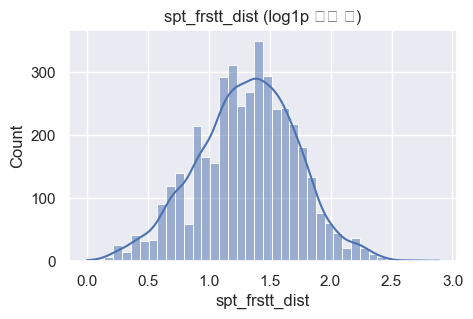

In [131]:
for col in log_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"{col} (log1p 변환 후)")
    plt.show()

## 타겟 설정
- 사망자수 0.4, 부상자수 0.3, 재산피해규모 0.3 으로 설정

In [133]:
scaler = MinMaxScaler()
df['prprty_dmge_amt'] = scaler.fit_transform(df[['prprty_dmge_amt']])

# 3. 혼합 타겟 계산 (가중치는 필요에 따라 조정)
df['target'] = (
    df['dth_cnt'] * 0.4 +     # 사망 여부
    df['injpsn_cnt'] * 0.3 +  # 부상 여부
    df['prprty_dmge_amt'] * 0.3 # 재산 피해
)
df.drop(columns=['dth_cnt','injpsn_cnt','prprty_dmge_amt'], inplace=True)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4163 entries, 0 to 5670
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ground_nof          4163 non-null   float64
 1   bstory_cnt          4039 non-null   float64
 2   totar               4163 non-null   float64
 3   bottom_area         4163 non-null   float64
 4   time_unit_tmprt     4163 non-null   float64
 5   time_unit_ws        4148 non-null   float64
 6   time_unit_wd        4148 non-null   float64
 7   time_unit_humidity  4163 non-null   int64  
 8   spt_frstt_dist      4163 non-null   float64
 9   strc_etc            4163 non-null   bool   
 10  strc_brick          4163 non-null   bool   
 11  strc_block          4163 non-null   bool   
 12  strc_wood           4163 non-null   bool   
 13  strc_steel          4163 non-null   bool   
 14  strc_src            4163 non-null   bool   
 15  strc_rc             4163 non-null   bool   
 16  target     

## 결측치 제거

In [135]:
df.isna().sum()

ground_nof              0
bstory_cnt            124
totar                   0
bottom_area             0
time_unit_tmprt         0
time_unit_ws           15
time_unit_wd           15
time_unit_humidity      0
spt_frstt_dist          0
strc_etc                0
strc_brick              0
strc_block              0
strc_wood               0
strc_steel              0
strc_src                0
strc_rc                 0
target                  0
dtype: int64

In [140]:
df = df.dropna()

In [141]:
# 인덱스 넘버 재정렬

df.reset_index(drop=True, inplace=True)

In [142]:
df.tail()

,ground_nof,bstory_cnt,totar,bottom_area,time_unit_tmprt,time_unit_ws,time_unit_wd,time_unit_humidity,spt_frstt_dist,strc_etc,strc_brick,strc_block,strc_wood,strc_steel,strc_src,strc_rc,target
4019,1.945910,1.098612,7.548203,5.371707,3.1,1.0,250.0,89,1.526056,False,False,False,False,False,False,True,0.164817
4020,2.944439,0.000000,8.981151,4.445119,3.1,1.0,250.0,89,0.788457,False,False,False,False,False,False,True,0.129125
4021,1.609438,0.693147,7.023759,5.620220,2.6,1.0,250.0,90,1.098612,False,False,False,False,False,False,True,0.089853
4022,3.367296,0.693147,9.345607,4.616209,1.3,1.0,340.0,95,1.064711,False,False,False,False,False,False,True,0.103727
4023,1.609438,0.693147,6.992877,5.621994,0.9,1.0,70.0,96,1.722767,False,False,False,False,False,False,True,0.070737


In [143]:
df.isna().sum()

ground_nof            0
bstory_cnt            0
totar                 0
bottom_area           0
time_unit_tmprt       0
time_unit_ws          0
time_unit_wd          0
time_unit_humidity    0
spt_frstt_dist        0
strc_etc              0
strc_brick            0
strc_block            0
strc_wood             0
strc_steel            0
strc_src              0
strc_rc               0
target                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ground_nof          4024 non-null   float64
 1   bstory_cnt          4024 non-null   float64
 2   totar               4024 non-null   float64
 3   bottom_area         4024 non-null   float64
 4   time_unit_tmprt     4024 non-null   float64
 5   time_unit_ws        4024 non-null   float64
 6   time_unit_wd        4024 non-null   float64
 7   time_unit_humidity  4024 non-null   int64  
 8   spt_frstt_dist      4024 non-null   float64
 9   strc_etc            4024 non-null   bool   
 10  strc_brick          4024 non-null   bool   
 11  strc_block          4024 non-null   bool   
 12  strc_wood           4024 non-null   bool   
 13  strc_steel          4024 non-null   bool   
 14  strc_src            4024 non-null   bool   
 15  strc_rc             4024 non-null   bool   
 16  target

## 상관관계

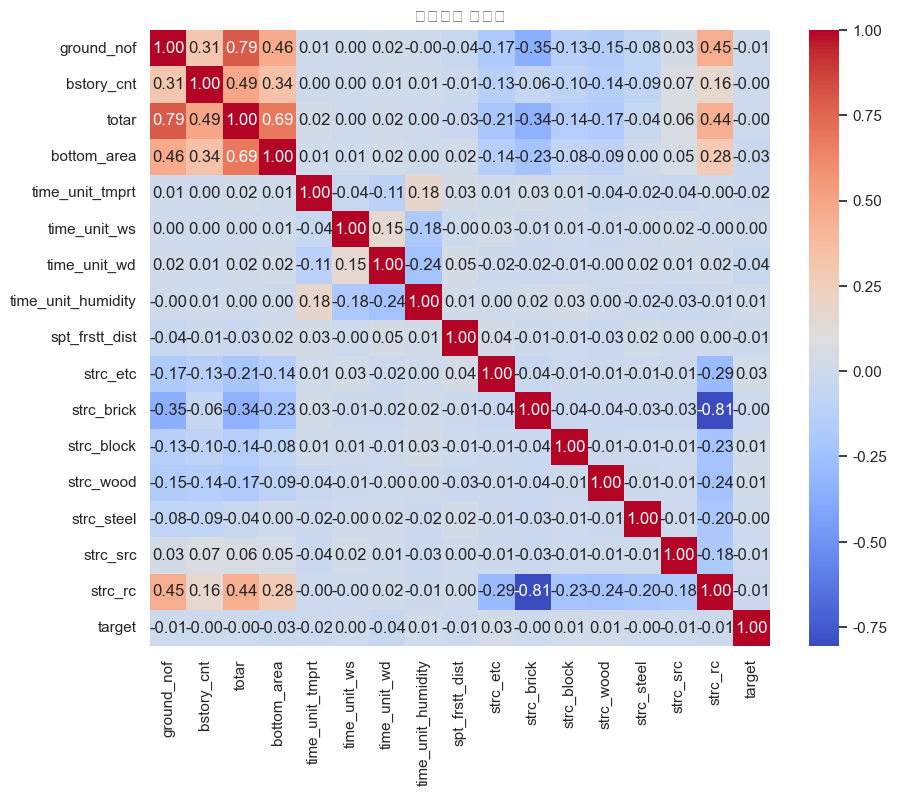

In [145]:
# 상관관계 계산
corr = df.corr()

# heatmap 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("상관관계 히트맵")
plt.show()

* 대부분 비선형 구조라서 비선형 모델을 써야 함
* RandomForest, XGBoost,LGBM 

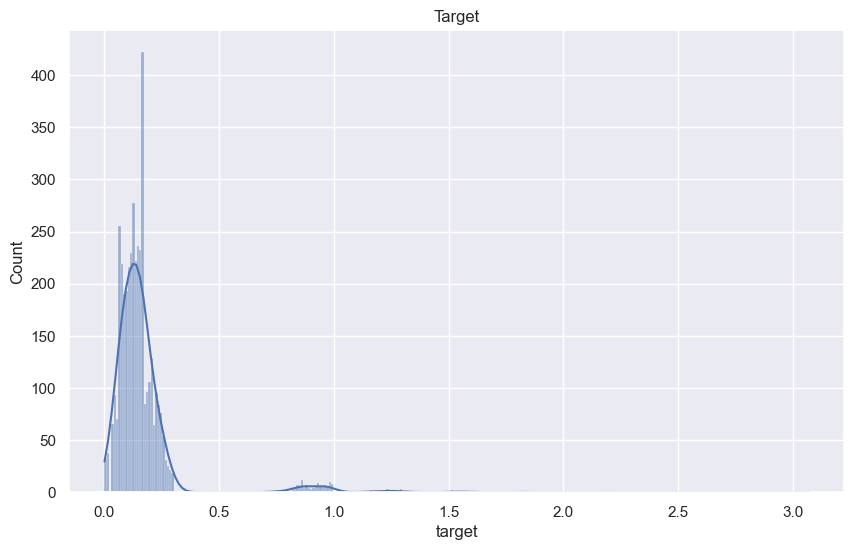

In [147]:
plt.figure(figsize=(10, 6))
sns.histplot(df['target'], kde=True) # kde=True는 분포를 부드러운 곡선으로 함께 보여줍니다.
plt.title('Target')
plt.show()

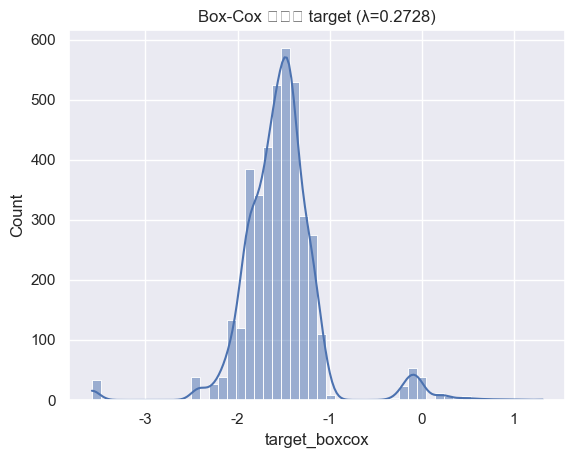

In [148]:
# 타겟의 왜도가 심해서 box-cox 변환

target_positive = df['target'] + 1e-6

# 2. Box-Cox 변환 (람다 자동 탐색)
df['target_boxcox'], best_lambda = boxcox(target_positive)

# 3. 시각화
sns.histplot(df['target_boxcox'], bins=50, kde=True)
plt.title(f"Box-Cox 변환된 target (λ={best_lambda:.4f})")
plt.show()

# 점수 확인

In [152]:
# X, y 지정 (Box-Cox된 타겟 사용)
X = df.drop(columns=['target_boxcox'])
y = df['target_boxcox']

# 훈련/검증 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


🔹 LightGBM 학습 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 3219, number of used features: 16
[LightGBM] [Info] Start training from score -1.533125
📉 RMSE: 0.4804
📈 R²: -0.0446

🔹 RandomForest 학습 시작
📉 RMSE: 0.4772
📈 R²: -0.0310

🔹 XGBoost 학습 시작
📉 RMSE: 0.4885
📈 R²: -0.0804


## LGBM

In [153]:
print("▶ LightGBM 학습")
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# 예측 + 역변환
lgb_pred = lgb_model.predict(X_val)
lgb_pred_original = inv_boxcox(lgb_pred, 0.2728)  # λ 값은 본인의 Box-Cox 값으로!

▶ LightGBM 학습
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 3219, number of used features: 16
[LightGBM] [Info] Start training from score -1.533125


## XGBoost

In [154]:
print("▶ XGBoost 학습")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)
xgb_pred_original = inv_boxcox(xgb_pred, 0.2728)

▶ XGBoost 학습


## RandomForest

In [155]:
print("▶ RandomForest 학습")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)
rf_pred_original = inv_boxcox(rf_pred, 0.2728)

▶ RandomForest 학습


## 모델 점수

In [156]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 실제값도 역변환해야 비교 가능
y_val_original = inv_boxcox(y_val, 0.2728)

print("\n📊 모델 성능 (RMSE)")
print("LGBM:", rmse(y_val_original, lgb_pred_original))
print("RandomForest:", rmse(y_val_original, rf_pred_original))
print("XGBoost:", rmse(y_val_original, xgb_pred_original))


📊 모델 성능 (RMSE)
LGBM: 0.20694107197971465
RandomForest: 0.2064813084021823
XGBoost: 0.2073624902001833


In [167]:
# LightGBM 저장
joblib.dump(lgb_model, 'lgbm_model.pkl')

# RandomForest 저장
joblib.dump(rf_model, 'rf_model.pkl')

# XGBoost 저장
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

## 세 모델 앙상블

In [157]:
ensemble_pred = (lgb_pred_original + rf_pred_original + xgb_pred_original) / 3

rmse_ensemble = np.sqrt(mean_squared_error(y_val_original, ensemble_pred))

print(f"🧪 앙상블 모델 성능 (RMSE): {rmse_ensemble:.6f}")

🧪 앙상블 모델 성능 (RMSE): 0.205265


## Z-Score
- 값들의 분포가 좁아서 Z-Score를 이용한 점수를 폭넓게 보이게 함

In [163]:
def scale_zscore_to_100(preds):
    mean = np.mean(preds)
    std = np.std(preds)
    z_scores = (preds - mean) / (std + 1e-6)
    scores = 50 + z_scores * 10
    return np.clip(scores, 0, 100)

# 4. 예측값 → 점수 변환
final_scores = scale_zscore_to_100(ensemble_pred)

# 5. 예시 출력
print("\n🎯 Z-score 기반 최종 점수 예시:")
print(final_scores[:10])


🎯 Z-score 기반 최종 점수 예시:
[34.30360004 43.36282568 45.03145318 35.16431587 44.38791307 47.19338167
 44.81657473 56.868543   46.79545152 52.46081555]


In [164]:
df.head()

,ground_nof,bstory_cnt,totar,bottom_area,time_unit_tmprt,time_unit_ws,time_unit_wd,time_unit_humidity,spt_frstt_dist,strc_etc,strc_brick,strc_block,strc_wood,strc_steel,strc_src,strc_rc,target,target_boxcox
0,2.197225,0.000000,6.898008,4.995115,1.5,1.0,290.0,74,0.587787,False,False,False,False,False,False,True,0.049414,-2.051887
1,1.386294,0.693147,7.044905,5.575949,-1.7,2.0,290.0,75,1.704748,False,False,False,False,False,False,True,0.068529,-1.901306
2,1.791759,0.693147,7.966306,6.993162,-0.4,2.0,270.0,66,1.029619,False,False,False,False,False,False,True,0.252459,-1.147572
3,1.386294,0.693147,5.879191,4.466023,3.0,3.0,270.0,45,1.435085,False,False,False,False,False,False,True,0.170661,-1.402681
4,2.772589,0.000000,9.266399,4.105120,3.8,3.0,250.0,38,0.993252,False,False,False,False,False,False,True,0.925100,-0.077031


# 가상데이터 예측

In [166]:
# 1. Box-Cox 람다값 (학습 시 사용한 값)
LAMBDA_VAL = 0.2728

# 2. 가상 입력 데이터 (로그 스케일)
new_data_dict = {
    'ground_nof': 2.197225,         # ln(9)
    'bstory_cnt': 0.693147,         # ln(2)
    'totar': 7.5,                   # ln(1800)
    'bottom_area': 5.2,             # ln(180)
    'time_unit_tmprt': 2.0,
    'time_unit_ws': 2.0,
    'time_unit_wd': 270.0,
    'time_unit_humidity': 70,
    'spt_frstt_dist': 1.2,
    'strc_etc': False,
    'strc_brick': False,
    'strc_block': False,
    'strc_wood': False,
    'strc_steel': False,
    'strc_src': True,
    'strc_rc': False
}

new_data = pd.DataFrame([new_data_dict])

# 3. 학습 시 사용한 컬럼 순서
trained_columns = new_data.columns.tolist()

# 4. 모델 예측 (Box-Cox 스케일에서)
pred_lgb = lgb_model.predict(new_data[trained_columns])[0]
pred_rf  = rf_model.predict(new_data[trained_columns])[0]
pred_xgb = xgb_model.predict(new_data[trained_columns])[0]

# 5. 앙상블 평균 → 역변환 (Box-Cox → 원래 단위)
ensemble_boxcox = (pred_lgb + pred_rf + pred_xgb) / 3
y_pred_original = inv_boxcox(ensemble_boxcox, LAMBDA_VAL)

# 6. Z-score 점수화 함수
def scale_zscore_to_100(preds, all_preds):
    mean = np.mean(all_preds)
    std = np.std(all_preds)
    z = (preds - mean) / (std + 1e-6)
    return np.clip(50 + 10 * z, 0, 100)

# 7. 전체 val 예측값 기준으로 스코어 환산
# y_val_original은 검증 세트의 실제 예측값 리스트여야 함
final_score = scale_zscore_to_100(y_pred_original, y_val_original)

# 8. 결과 출력
print(f"📌 예측된 피해 점수 (원래 scale): {y_pred_original:.4f}")
print(f"🎯 환산된 최종 스코어 (Z-score): {final_score:.1f}점")

📌 예측된 피해 점수 (원래 scale): 0.1242
🎯 환산된 최종 스코어 (Z-score): 47.4점


In [168]:
df.to_csv('fire0622.csv', index=False, encoding='utf-8-sig')